In [33]:
import pandas as pd
import numpy as p
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import spacy

from sklearn.model_selection import train_test_split
from time import time
from sklearn.preprocessing import LabelEncoder

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Reading data

In [3]:
# download the data from kaggle
train_df=pd.read_csv("train.csv")

In [4]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# Checking missing values

In [8]:
print("Check for missing values in dataset: ", train_df.isnull().sum().sum())

Check for missing values in dataset:  0


# Exploratory data analysis

Let's check how many articles are included in each category.

In [9]:
categories=["Computer Science","Physics","Mathematics","Statistics","Quantitative Biology","Quantitative Finance"]
category_count=[]
for i in categories:
  category_count.append(train_df[i].sum()) 

Text(0.5, 1.0, 'Number of articles in each category')

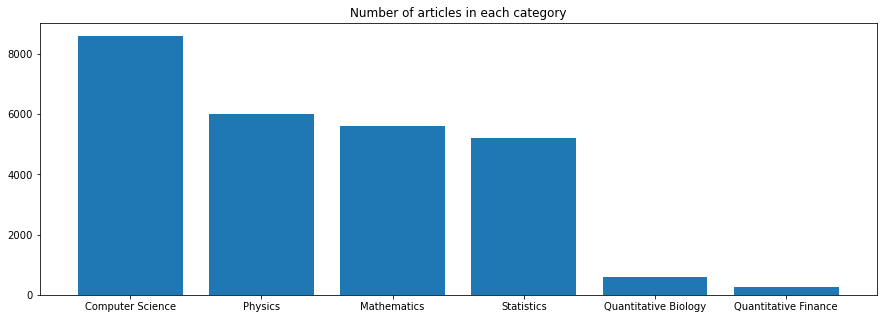

In [10]:
plt.figure(figsize=(15,5))
plt.bar(categories,category_count)
plt.title("Number of articles in each category")

Conclusion: The dataset is imbalanced. We can see that there are significantly more articles belonging to the Computer Science category than to the Quantitative Biology or Quantitative Finance categories.

In [12]:
total_word_count_in_each_category=[]
for i in categories:
  abstracts = train_df.where(train_df[i]==1)[['ABSTRACT']] 
  count=pd.Series(abstracts.values.flatten()).str.len().sum()
  total_word_count_in_each_category.append(count)

In [13]:
avg_abstract_len_for_each_category=[]
for i in range(6):
  avg_abstract_len_for_each_category.append(total_word_count_in_each_category[i]/category_count[i])

Now we can see the average number of words contained in an article of each category.

Text(0.5, 1.0, 'Average word length of abstract for each category')

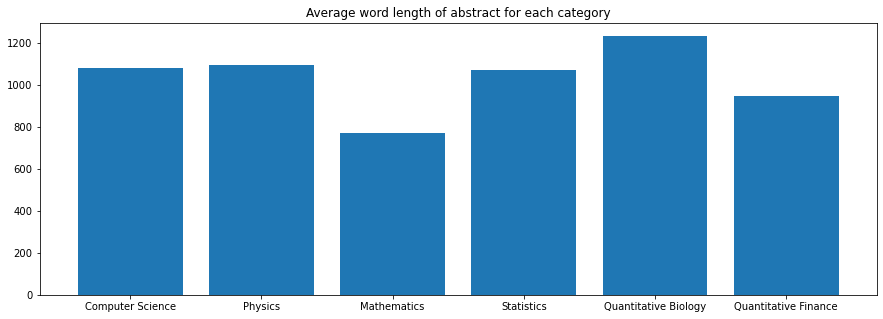

In [10]:
plt.figure(figsize=(15,5))
plt.bar(categories,avg_abstract_len_for_each_category)
plt.title("Average word length of abstract for each category")

From the above plot its clear that articles of quantitaive biology are longest, and mathematics articles are shortest.

In [12]:
count_numeric_contained_texts=dict()
for category in categories:
    count_numeric_contained_texts[category]=0

In [13]:
for category in categories:
    for text in train_df[train_df[category]==1]["ABSTRACT"]:
        if re.findall("\d",text):
            count_numeric_contained_texts[category]+=1 

In [14]:
for i in range(len(categories)):
    count_numeric_contained_texts[categories[i]]=count_numeric_contained_texts[categories[i]]/category_count[i]

Now we can see the average number of numeric values contained in an article of each category.

<BarContainer object of 6 artists>

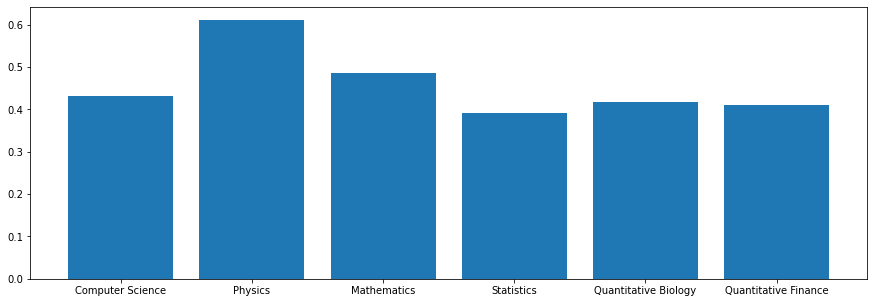

In [15]:
plt.figure(figsize=(15,5))
plt.bar(categories,count_numeric_contained_texts.values())

Each category have numeric values in almost 40% texts except physics, also physics doesnt have significant difference, so numeric values in abstracts doesnt add any significant difference between categories, so we will just remove the numeric values from text preprocessing step.

# Data preprocessing

Concatenation of Title and Abstract to make it one text

In [15]:
train_df["text"]=train_df["TITLE"] +" "+ train_df["ABSTRACT"]

Dropping the TITLE and ABSTRACT columns.

In [16]:
train_df.drop(["TITLE","ABSTRACT"], axis=1,inplace=True)

In [17]:
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


In [21]:
def split(X, y,test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)
    return (X_train, X_test, y_train, y_test)

# Lemmatizing

Performing lemmatization of words and regular expressions using the spacy library.

In [20]:
import spacy
print(spacy.__file__) 

C:\Users\LEGION\anaconda3\lib\site-packages\spacy\__init__.py


In [21]:
nlp=spacy.load('en_core_web_sm',disable=['ner','parser'])

Replace non-letter characters with a space and convert all uppercase letters to lowercase.

In [22]:
brief_cleaning=(re.sub("[^a-zA-Z]+"," ",str(text)).lower() for text in train_df["text"])

In [23]:
def cleaning(doc):
    txt=[token.lemma_ for token in doc if not token.is_stop]
    txt=[txt for txt in txt if len(txt)>1]
    return " ".join(txt)

In [24]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=2000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 4.6 mins


In [25]:
cleaned_title2=[]
for i in range(train_df.shape[0]):
    title1=train_df.text[i] 
    title1=title1.lower().strip() 
    title1=re.sub("\n"," ",title1) 
    title1=re.sub("[^a-zA-Z0-9 +]"," ",title1)
    title1=nlp(title1) 
    title1=[token.lemma_.strip() for token in title1 if (not token.is_stop) and (len(token)>1)]
    title1=" ".join(title1)
    title1=re.sub(" +"," ",title1)
    cleaned_title2.append(title1)

Save this cleaned text to a csv file so that we don't have run above cell every time because it is time taking.

In [26]:
df1 = pd.DataFrame(cleaned_title2)
df1.to_csv("cleaned_text_2.csv")

In [25]:
cleaned_text=pd.read_csv("cleaned_text_2.csv")
cleaned_text=list(cleaned_text['0'].values)
cleaned_text[:3]

['reconstruct subject specific effect map predictive model allow subject specific inference analyze disease relate alteration neuroimage datum give subject data inference level global identifiye condition presence subject local detect condition effect individual measurement extract subject data global inference widely local inference form subject specific effect map rarely exist model yield noisy detection compose disperse isolate island article propose reconstruction method name rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise sample error associate finite sample example train classifier propose method wrapper type algorithm different binary classifier diagnostic manner information condition presence reconstruction pose maximum posteriori problem prior model parameter estimate train datum classifier specific fashion experimental evaluation perform synthetically generate datum datum alzheimer disease neur

In [6]:
len(cleaned_text)

20972

In [26]:
train_df['cleaned_text']=cleaned_text
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,cleaned_text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...,reconstruct subject specific effect map predic...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...,rotation invariance neural network rotation in...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonic poisson kernel polyharm...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...,finite element approximation stochastic maxwel...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,comparative study discrete wavelet transform w...


In [58]:
X = train_df.loc[:,"cleaned_text"]
y = train_df.loc[:,categories]

In [59]:
X.shape,y.shape

((20972,), (20972, 6))

Checking the lengths of texts and presenting them on a histogram.

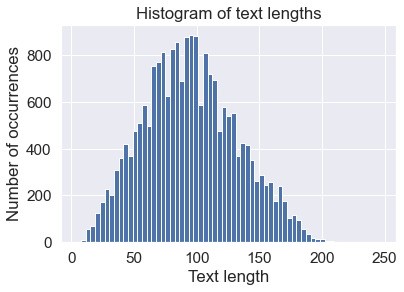

In [60]:
lengths = [len(text.split()) for text in list(X)]

plt.hist(lengths, bins='auto')
plt.xlabel('Text length')
plt.ylabel('Number of occurrences')
plt.title('Histogram of text lengths')
plt.show()

In [97]:
X_train,X_test,y_train,y_test=split(X,y,0.2)

In [98]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((16777,), (4195,), (16777, 6), (4195, 6))

# Tokenization and Padding

Due to the fact that the majority of articles consist of around 100 words, we set the length of our tokens to 100.

In [38]:
max_length = 100

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)

In [40]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

Tworzymy tokeny liczb odpowiadających miejscom w słowniku oraz padding który uogólnia długość wektorów do jednej liczbt max_length

In [41]:
print(X_test_seq[1])

[2602, 770, 2129, 960, 2602, 770, 212, 239, 1780, 770, 66, 344, 2, 331, 333, 581, 119, 28, 838, 22, 1627, 2602, 770, 428, 2129, 1045, 2, 7, 121, 28, 12, 647, 3312, 8, 10, 2602, 770, 268, 3, 27, 166, 1646, 2602, 770, 476, 6844, 3008, 24902, 56, 590, 40]


In [42]:
print(X_train_pad[1])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  1408    42   245    14    82  4693     6  2498   756
    46  4005  4470  2894   756  4243  6378   190  4693     6   756   833
    46  4005  4470  2894   756   756  1764    40  1764  1385 26420  3206
  4470  1033 16698 12657  6378  2933  1795 16698 16698  3206  4470  1033
 26421 12657  6378  2933  1795   182  1385   182    40 12657  6378 26422
  6378  1650  4693     6   711    41  1196    46  4005  4470  2894  1196
    24  2498  2124  1196   833    46  4005  4470  4005  6379  2894   756
  4177  1988   250   309]


# Creating an LSTM model with an Embedding layer

In [43]:
vocab_size = len(tokenizer.word_index) +1
embedding_dim = 50
vocab_size

42134

In [44]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=128))
model.add(Dense(units=6, activation='softmax'))

In [48]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test))

Epoch 1/10
525/525 [==============================] - 60s 111ms/step - loss: 1.9725 - accuracy: 0.4041 - val_loss: 1.9380 - val_accuracy: 0.4033
Epoch 2/10
525/525 [==============================] - 58s 110ms/step - loss: 1.9338 - accuracy: 0.4090 - val_loss: 1.9540 - val_accuracy: 0.4033
Epoch 3/10
525/525 [==============================] - 59s 112ms/step - loss: 1.7734 - accuracy: 0.5523 - val_loss: 1.6441 - val_accuracy: 0.6284
Epoch 4/10
525/525 [==============================] - 59s 112ms/step - loss: 1.5756 - accuracy: 0.6548 - val_loss: 1.5587 - val_accuracy: 0.6942
Epoch 5/10
525/525 [==============================] - 59s 113ms/step - loss: 1.4874 - accuracy: 0.7466 - val_loss: 1.5394 - val_accuracy: 0.7299
Epoch 6/10
525/525 [==============================] - 60s 114ms/step - loss: 1.4611 - accuracy: 0.7842 - val_loss: 1.5110 - val_accuracy: 0.7423
Epoch 7/10
525/525 [==============================] - 61s 117ms/step - loss: 1.4577 - accuracy: 0.7969 - val_loss: 1.5881 - val_ac

# Visualization of results


In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y,y_pred):
    c_matrix=confusion_matrix(y,y_pred)

    c_matrix=pd.DataFrame(c_matrix,columns=['Computer Science',
     'Physics',
     'Mathematics',
     'Statistics',
     'Quantitative Biology',
     'Quantitative Finance'],index=['Computer Science',
     'Physics',
     'Mathematics',
     'Statistics',
     'Quantitative Biology',
     'Quantitative Finance'])

    fig,ax=plt.subplots(figsize=(12,12))
    sns.set(font_scale=1.4)
    sns.heatmap(c_matrix/np.sum(c_matrix),fmt="0.2%",annot=True,cmap="Blues",ax=ax)
    ax.set_title("Confusion matrix ",fontsize=26)
    ax.set_xlabel("Predicted",fontsize=26)
    ax.set_ylabel("Actual",fontsize=26)

We encode class labels into numerical values.

In [50]:
y_test=y_test.idxmax(axis='columns')
y_train=y_train.idxmax(axis='columns')

In [51]:
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)

In [52]:
import numpy as np
y_train_pred = np.argmax(model.predict(X_train_pad), axis=-1)
y_test_pred = np.argmax(model.predict(X_test_pad), axis=-1)

132/132 [==============================] - 3s 25ms/step


In [53]:
y_test_pred

array([0, 0, 0, ..., 2, 1, 0], dtype=int64)

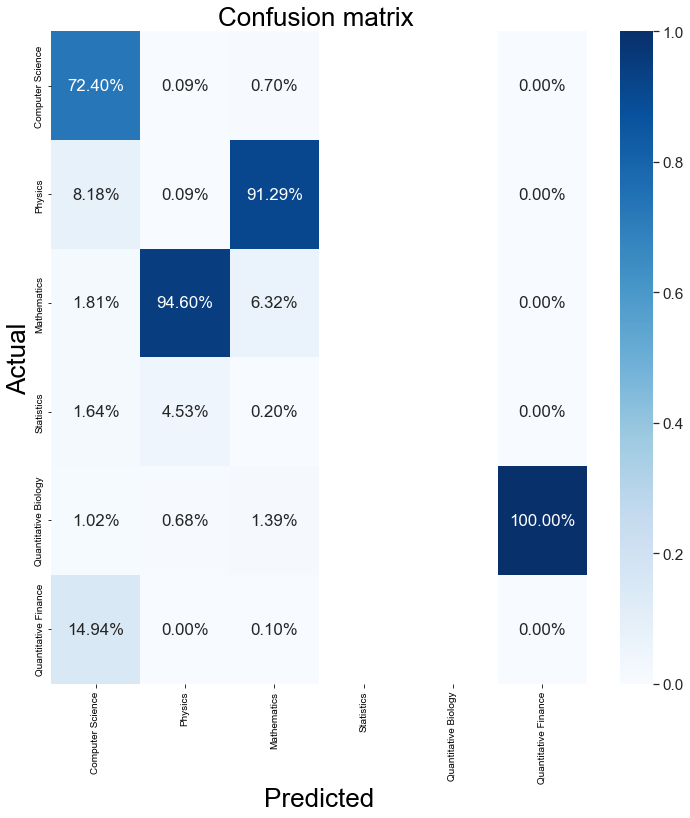

In [54]:
plot_confusion_matrix(y_train, y_train_pred)

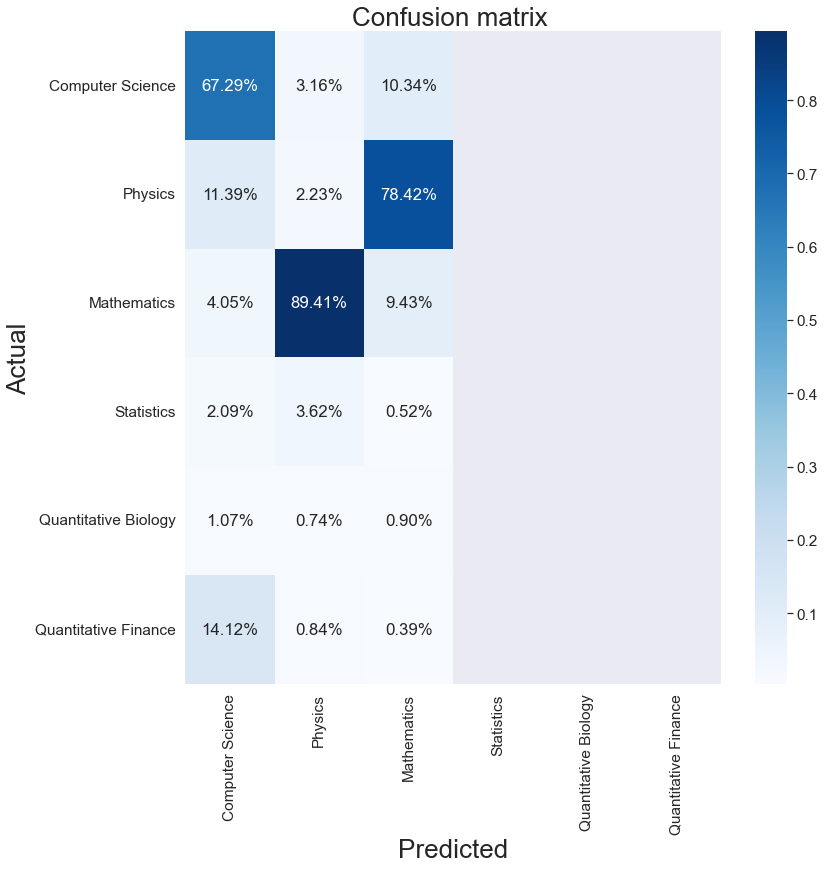

In [56]:
plot_confusion_matrix(y_test, y_test_pred)

We can see that in most cases, the data is misclassified. Furthermore, due to data imbalance, we also observe empty cells in the confusion matrix.

# Oversampling

In [101]:
from imblearn.over_sampling import RandomOverSampler

In [102]:
le=LabelEncoder()
y_num=le.fit_transform(y.idxmax(axis='columns'))

In [103]:
ros = RandomOverSampler(random_state=42)
X_np = np.array(X).reshape(-1, 1)
X_resampled, y_resampled = ros.fit_resample(X_np, y_num)

In [104]:
X_resampled.shape

(51564, 1)

In [105]:
category_count_sampling = []
for i in range(len(categories)):
  category_count_sampling.append(y_resampled[y_resampled == i].shape[0]) 

Text(0.5, 1.0, 'Number of articles in each category')

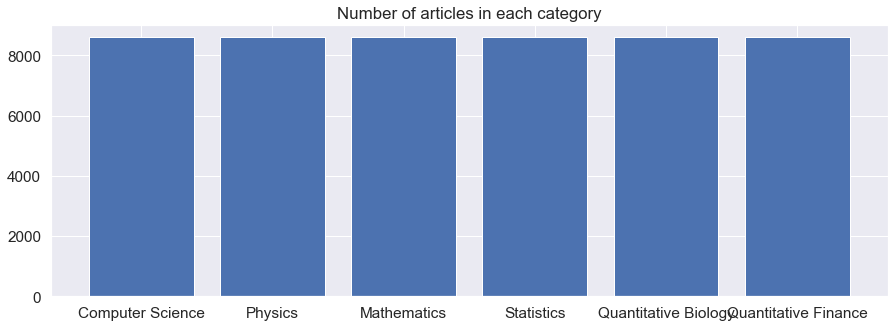

In [106]:
plt.figure(figsize=(15,5))
plt.bar(categories,category_count_sampling)
plt.title("Number of articles in each category")

In [115]:
X_resampled.shape

(51564, 1)

In [118]:
X_resampled = pd.Series(X_resampled.flatten())

In [119]:
X_train,X_test,y_train,y_test=split(X_resampled,y_resampled,0.2)

In [120]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((41251,), (10313,), (41251,), (10313,))

# Tokenization and padding after oversampling the data

In [121]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [122]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)

In [123]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Creating an LSTM model with an Embedding layer

In [124]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50
vocab_size

43875

In [152]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=128))
model.add(Dense(units=6, activation='softmax'))

In [133]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

y_reshaped = y_train.reshape(-1, 1)
y_reshaped_test = y_test.reshape(-1, 1)
y_encoded = encoder.fit_transform(y_reshaped)
y_encoded_test = encoder.fit_transform(y_reshaped_test)

print(y_encoded)

[[0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [153]:
from keras.callbacks import EarlyStopping

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
his = model.fit(X_train_pad, y_encoded, batch_size=32, epochs=10, validation_data=(X_test_pad, y_encoded_test),callbacks=[es])

Epoch 1/10
1290/1290 [==============================] - 145s 111ms/step - loss: 0.7231 - accuracy: 0.6898 - val_loss: 0.4096 - val_accuracy: 0.8408
Epoch 2/10
1290/1290 [==============================] - 144s 112ms/step - loss: 0.2821 - accuracy: 0.8977 - val_loss: 0.2728 - val_accuracy: 0.9115
Epoch 3/10
1290/1290 [==============================] - 140s 108ms/step - loss: 0.1727 - accuracy: 0.9450 - val_loss: 0.2579 - val_accuracy: 0.9187
Epoch 4/10
1290/1290 [==============================] - 139s 108ms/step - loss: 0.0944 - accuracy: 0.9707 - val_loss: 0.2463 - val_accuracy: 0.9292
Epoch 5/10
1290/1290 [==============================] - 146s 113ms/step - loss: 0.0871 - accuracy: 0.9744 - val_loss: 0.2468 - val_accuracy: 0.9334
Epoch 6/10
1290/1290 [==============================] - 149s 116ms/step - loss: 0.0405 - accuracy: 0.9880 - val_loss: 0.2382 - val_accuracy: 0.9435
Epoch 7/10
1290/1290 [==============================] - 141s 109ms/step - loss: 0.0346 - accuracy: 0.9905 - val_

# Visualization of results

In [135]:
y_train_pred = np.argmax(model.predict(X_train_pad), axis=-1)
y_test_pred = np.argmax(model.predict(X_test_pad), axis=-1)

323/323 [==============================] - 9s 29ms/step


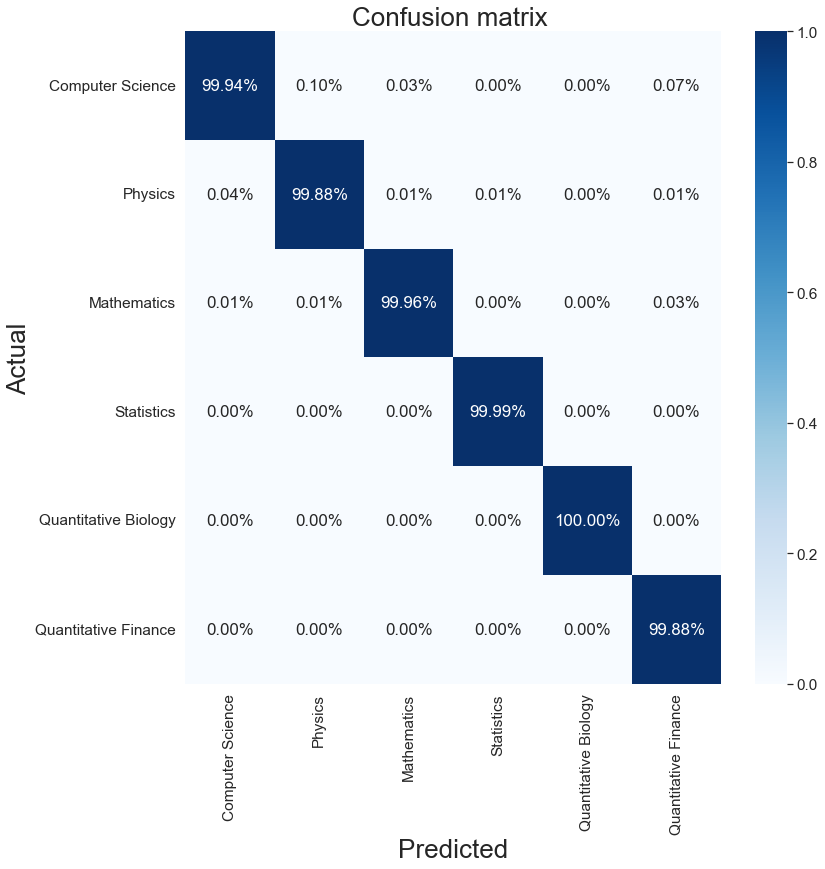

In [136]:
plot_confusion_matrix(y_train, y_train_pred)

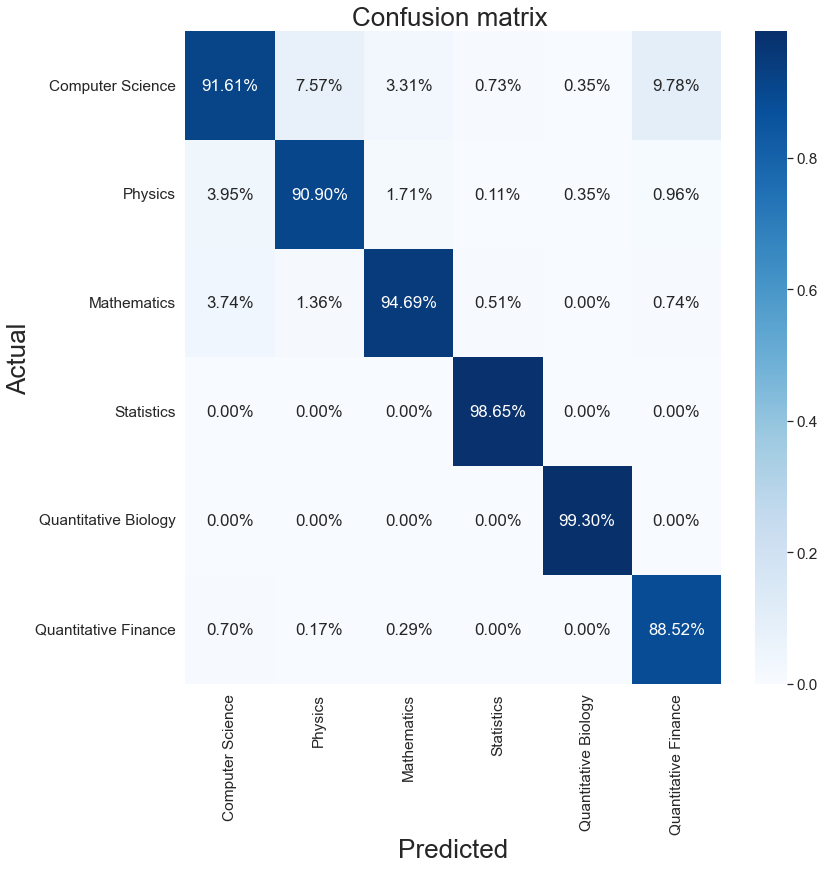

In [137]:
plot_confusion_matrix(y_test, y_test_pred)

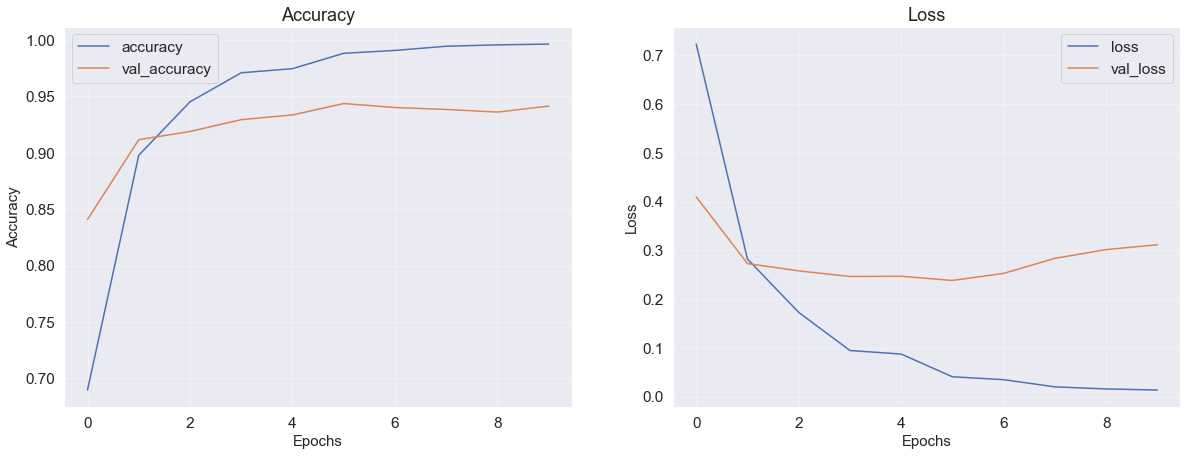

In [156]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)


plt.plot(his.epoch, his.history['accuracy'], label = "accuracy")
plt.plot(his.epoch, his.history['val_accuracy'], label = "val_accuracy")

plt.title("Accuracy", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

fig.add_subplot(122)

plt.plot(his.epoch, his.history['loss'], label="loss")
plt.plot(his.epoch, his.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()